All citations in project readme file.

In [1]:
#hide
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import arviz as az
import pymc3 as pm
import altair as alt

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

## Set this to true to see legacy charts
debug=False

from c19_load import load_single_country

In [2]:
CTRY = 'Singapore'

CONFIRMED__COLNAME = 'total'
ACTIVE__COLNAME = 'active'
DISCHARGED__COLNAME = 'discharged'

LAST_DAYS = 21

annotate_kwargs = dict(
    s='Based on COVID Data Repository by Johns Hopkins CSSE \nbryan.blacbee', 
    xy=(0.05, 0.01), xycoords='figure fraction', fontsize=10)

In [3]:
df_sg = load_single_country(country=CTRY)
t_100cases = df_sg[df_sg.total>100].index.min()
df_sg['t'] = df_sg.index
df_sg['t_s100'] = df_sg['t'].apply(lambda x: x-t_100cases)
df_sg = df_sg[df_sg.t_s100>=0] # Start from t_s100=0

In [4]:
df_sg

,country,date,total,new,deaths,discharged,active,t,t_s100
38,Singapore,2020-02-29,102,9,0,72,30,38,0
39,Singapore,2020-03-01,106,4,0,72,34,39,1
40,Singapore,2020-03-02,108,2,0,78,30,40,2
41,Singapore,2020-03-03,110,2,0,78,32,41,3
42,Singapore,2020-03-04,110,0,0,78,32,42,4
43,Singapore,2020-03-05,117,7,0,78,39,43,5
44,Singapore,2020-03-06,130,13,0,78,52,44,6
45,Singapore,2020-03-07,138,8,0,78,60,45,7
46,Singapore,2020-03-08,150,12,0,78,72,46,8
47,Singapore,2020-03-09,150,0,0,78,72,47,9


In [5]:
with pm.Model() as model:
    
    ############
    # Intercept
    # Group mean
    a_grp = pm.Normal('a_grp', 100, 50)
    # Group variance
    a_grp_sigma = pm.HalfNormal('a_grp_sigma', 50)
    # Individual intercepts
    a_ind = pm.Normal('a_ind', 
                      mu=a_grp, sigma=a_grp_sigma, 
                      shape=1)    

    ########
    # Slope
    # Group mean
    b_grp = pm.Normal('b_grp', 1.33, .5)
    # Group variance
    b_grp_sigma = pm.HalfNormal('b_grp_sigma', .5)
    # Individual slopes
    b_ind = pm.Normal('b_ind', 
                      mu=b_grp, sigma=b_grp_sigma, 
                      shape=1)    
    
    sigma = pm.HalfNormal('sigma', 500., shape=1)    
    
    x = pm.Data(CTRY + "x_data", 
                df_sg.t_s100.values)
    confirmed = pm.Data(CTRY + "y_data", 
                        df_sg.total.astype('float64').values)

    # Likelihood
    pm.NegativeBinomial(
        CTRY, 
        (a_ind[0] * b_ind[0] ** x), # Exponential regression
        sigma[0], 
        observed=confirmed)    

In [6]:
#hide
with model:
    # Sample posterior
    trace = pm.sample(tune=1500, chains=1, cores=2, target_accept=.9)
    
    # Update data so that we get predictions into the future
    x_data = np.arange(0, 30)
    y_data = np.array([np.nan] * len(x_data))
    pm.set_data({CTRY + "x_data": x_data})
    pm.set_data({CTRY + "y_data": y_data})
    
    # Sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace, samples=80)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, b_ind, b_grp_sigma, b_grp, a_ind, a_grp_sigma, a_grp]
Sampling chain 0, 49 divergences: 100%|██████████| 2000/2000 [00:21<00:00, 92.44it/s] 
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8098876617023503, but should be close to 0.9. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/bryanlim/.pyenv/versions/3.7.2/envs/interviews/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 80/80 [00:00<00:00, 89.15it/s]


In [7]:
post_pred

{'Singapore': array([[ 61,  98,  83, ..., 641, 745, 843],
        [ 75,  77,  64, ..., 638, 715, 779],
        [ 84,  93, 101, ..., 743, 742, 900],
        ...,
        [ 76,  89,  88, ..., 665, 706, 829],
        [ 78,  84,  98, ..., 674, 758, 837],
        [ 96,  80,  94, ..., 752, 784, 823]])}

In [8]:
arr = post_pred[CTRY]
preds = arr.flatten().tolist() # get predictions in a flattened array
pred_idx = np.indices(arr.shape)[0].flatten().tolist() # prediction for model (there are many per country, thes are the grey lines)
days_since = np.indices(arr.shape)[1].flatten().tolist() # days since 100 cases
pred_df = pd.DataFrame({'country': CTRY, 
                        'predictions': preds, 
                        'pred_idx': pred_idx,
                        'days_since_100': days_since}
                      )

In [9]:
ylims = pd.DataFrame(df_sg.groupby('country').last().total*15).reset_index()
ylims.columns = ['country', 'ylim']
ylims

,country,ylim
0,Singapore,13890


In [10]:
predictionsDF_filtered = (pred_df.merge(ylims, on='country', how='left')
                         .loc[lambda x: x.predictions <= x.ylim])

In [11]:
first_case_count = df_sg.groupby('country').first().total.reset_index()
date_anchor = predictionsDF_filtered[['country', 'days_since_100']].drop_duplicates()
max_pred = predictionsDF_filtered.groupby('country').max()[['predictions']].reset_index()
benchmark = (date_anchor
             .merge(first_case_count, on='country', how='left')
             .merge(max_pred, on='country', how='left')
            )
benchmark
benchmark['benchmark'] = benchmark.apply(lambda x: x.total * (1.3**(x.days_since_100)),
                                         axis=1)
benchmarkDF_filtered = benchmark.loc[lambda x: x.benchmark <= x.predictions]

In [12]:
lastpointDF = df_sg.groupby('country').last().reset_index()

In [13]:
titleDF = lastpointDF[['country']]
titleDF['title'] = titleDF.apply(lambda x: x.country + ': Actual vs. Predicted Growth',
                             axis=1)

/Users/bryanlim/.pyenv/versions/3.7.2/envs/interviews/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
alt.data_transformers.disable_max_rows()

selectCountry = alt.selection_single(
    name='Select',
    fields=['country'],
    init={'country': 'Singapore'},
    bind=alt.binding_select(options=sorted(['Singapore']))
)

##### Model Predictions (Grey) #####
width = 275
height= 250

pred = (alt.Chart(predictionsDF_filtered)
        .mark_line(opacity=.15)
        .encode(x=alt.X('days_since_100:Q', axis=alt.Axis(title='Days since 100th confirmed case')),
                y=alt.Y('predictions:Q', 
                        axis=alt.Axis(title='Confirmed cases')),
                color=alt.Color('pred_idx:Q', legend=None, scale=None),)
        .transform_filter(selectCountry)
       ).properties(
    width=width,
    height=height
)  

predlog = (alt.Chart(predictionsDF_filtered)
        .mark_line(opacity=.15)
        .encode(x=alt.X('days_since_100:Q', axis=alt.Axis(title='Days since 100th confirmed case')),
                y=alt.Y('predictions:Q', 
                        axis=alt.Axis(title=None),
                        scale=alt.Scale(type='log', base=10)),
                color=alt.Color('pred_idx:Q', legend=None, scale=None),)
        .transform_filter(selectCountry)
        ).properties(
    width=width,
    height=height
)   

##### Mark The Last Case Count #####

# Point

last_point = (alt.Chart(lastpointDF)
              .mark_circle(color="black", size=40)
              .encode(x='days_since_100:Q',
                      y='total:Q')
              .transform_filter(selectCountry)
             )

# Label
last_point_label = (alt.Chart(lastpointDF)
                    .mark_text(align='right', dx=-10, dy=-15, fontSize=15)
                    .encode(x='days_since_100:Q',
                            y='total:Q',
                            text='total')
                    .transform_filter(selectCountry)
                   )

##### Place 133% Dotted Line Reference On Graph #####
guide = (alt.Chart(benchmarkDF_filtered)
        .mark_line(color='black', opacity=.5, strokeDash=[3,3])
        .encode(x='days_since_100:Q',
                y='benchmark:Q',
                )
        .transform_filter(selectCountry)
        )


##### Dynamic Chart Title


title_main = alt.Chart(titleDF).mark_text(dy=-15, dx=325, size=20).encode(
    text='title:N'
    ).transform_filter(selectCountry)


title_linear = (alt.Chart(alt.Data(values=[{'title': 'Y axis is on a linear scale'}]))
                .mark_text(dy=-150, size=15)
                .encode(text='title:N')
               )
title_log = (alt.Chart(alt.Data(values=[{'title': 'Y axis is on a log scale'}]))
                .mark_text(dy=-150, size=15)
                .encode(text='title:N')
               )

# ###### Legend (Hacked)
source = pd.DataFrame.from_records([{"img": "https://covid19dashboards.com/images/covid-bayes-growth-legend.png"}])
legend = (alt.Chart(source)
          .mark_image(dy=-150,
                      width=200,
                      height=150)
          .encode(url='img')
         )

##### Actual Cases (Red) #####
actual = (alt.Chart(df_sg).mark_line(color="red")
          .encode(x='days_since_100:Q',
                  y='confirmed:Q')
          .transform_filter(selectCountry)
         )

annotations = last_point + last_point_label + guide + actual
linear_chart = pred.add_selection(selectCountry) + annotations + title_linear
log_chart = predlog + annotations + title_log + title_log

##### Layer All Charts Together And Configure Formatting #####
(
((title_main + legend) & ( linear_chart | log_chart ))
.configure_title(fontSize=20)
.configure_axis(labelFontSize=15,titleFontSize=18, grid=False)
)

alt.VConcatChart(...)

Text(0.5, 0.98, 'Posterior of daily growth')

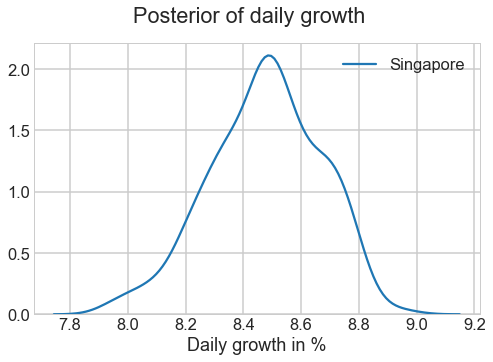

In [15]:
fig, ax = plt.subplots(nrows=1, figsize=(8, 5), sharex=True)
sns.distplot((trace['b_ind'][:] * 100) - 100, ax=ax, label='Singapore', hist=False)
ax.set_xlabel('Daily growth in %')
plt.suptitle('Posterior of daily growth')

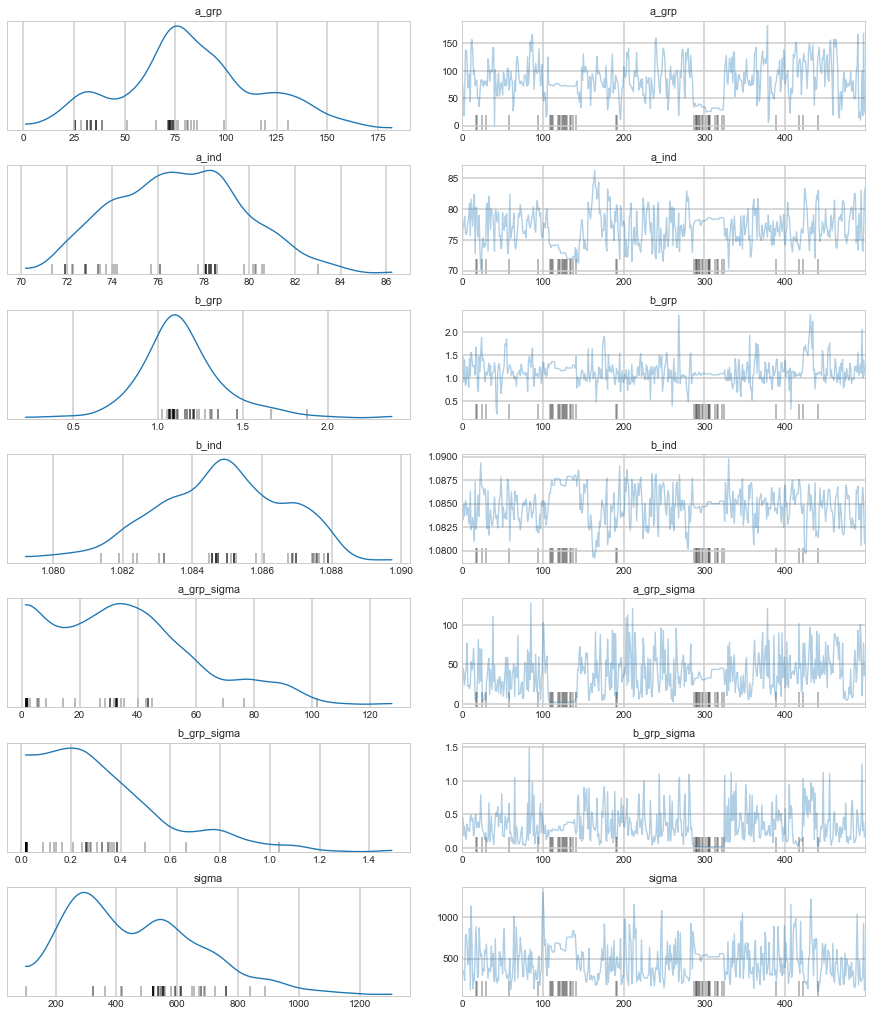

In [16]:
az.plot_trace(trace, compact=True);